## Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

## 1. Obtain the Data: Get the Dogs vs Cats dataset (see CSCN8010 class notebook)

### Run below code, so we can get 5000 images instead of 25000 images, and save images into kaggle_dogs_vs_cats_small folder.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("../data/kaggle_dogs_vs_cats/train")
new_base_dir = pathlib.Path("../data/kaggle_dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [5]:

# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## 2.EDA: Explore the data with relevant graphs, statistics and insights (5 points)

Dataset Info:
Train dataset size: 63
Validation dataset size: 32
Test dataset size: 63

Class names: ['cat', 'dog']

Images per class in training set: {'cat': 1000, 'dog': 1000}


2024-11-23 12:20:16.308261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-11-23 12:20:16.308825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


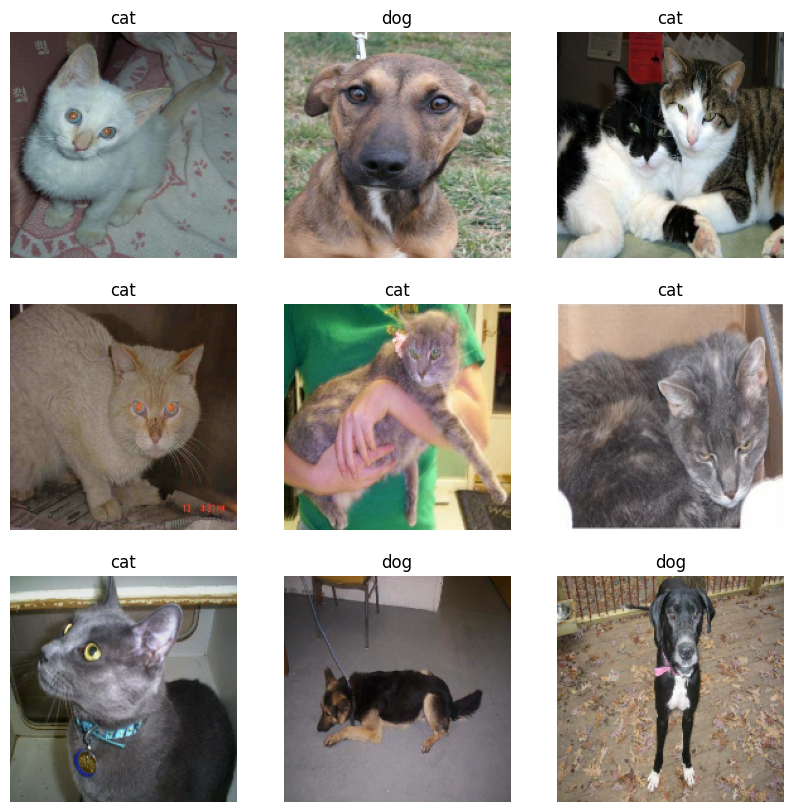


Image Statistics:
Mean pixel value: 113.95
Std pixel value: 65.51


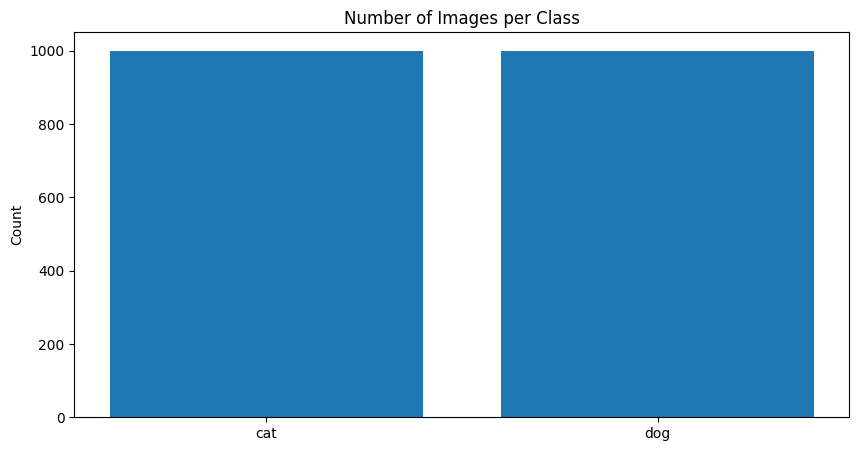

2024-11-23 12:20:20.350424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-11-23 12:20:20.351295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]



Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# base info
print("Dataset Info:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# class names
class_names = train_dataset.class_names
print("\nClass names:", class_names)

# image counts
def count_images_per_class(dataset):
    counts = {name: 0 for name in class_names}
    for images, labels in dataset:
        for label in labels:
            counts[class_names[label.numpy()]] += 1
    return counts

train_counts = count_images_per_class(train_dataset)
print("\nImages per class in training set:", train_counts)

# check some images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# image statistics
def analyze_image_statistics(dataset):
    pixel_mean = []
    pixel_std = []
    for images, _ in dataset:
        pixel_mean.append(tf.reduce_mean(images))
        pixel_std.append(tf.math.reduce_std(images))
    
    return {
        'mean': tf.reduce_mean(pixel_mean),
        'std': tf.reduce_mean(pixel_std)
    }

stats = analyze_image_statistics(train_dataset)
print("\nImage Statistics:")
print(f"Mean pixel value: {stats['mean']:.2f}")
print(f"Std pixel value: {stats['std']:.2f}")

# show images
plt.figure(figsize=(10, 5))
plt.bar(class_names, list(train_counts.values()))
plt.title('Number of Images per Class')
plt.ylabel('Count')
plt.show()

# check batch shape
for image_batch, labels_batch in train_dataset.take(1):
    print("\nImage batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

### Summary:

1000 each for cats/dogs, prefect balanced data, efficient batch size of 32, and consistent 180x180 RGB images providing rich color information for feature extraction.

## 3.Train two networks (use callbacks to save the best model version)

### 3.1 Define a Neural Network of your choice

In [13]:
from tensorflow.keras import layers, models

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_1123.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 63s 968ms/step - loss: 0.7014 - accuracy: 0.5150 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 65s 1s/step - loss: 0.6924 - accuracy: 0.5345 - val_loss: 0.6905 - val_accuracy: 0.5030
Epoch 3/30
63/63 [==============================] - 58s 923ms/step - loss: 0.6814 - accuracy: 0.5595 - val_loss: 0.6537 - val_accuracy: 0.6100
Epoch 4/30
63/63 [==============================] - 61s 972ms/step - loss: 0.6475 - accuracy: 0.6210 - val_loss: 0.6365 - val_accuracy: 0.6600
Epoch 5/30
63/63 [==============================] - 64s 1s/step - loss: 0.6184 - accuracy: 0.6715 - val_loss: 0.6036 - val_accuracy: 0.6630
Epoch 6/30
63/63 [==============================] - 60s 949ms/step - loss: 0.6016 - accuracy: 0.6940 - val_loss: 0.5767 - val_accuracy: 0.6990
Epoch 7/30
63/63 [==============================] - 63s 1s/step - loss: 0.5344 - accuracy: 0.7365 - val_loss: 0.7745 - val_accuracy: 0.6030
Epoch 8/

**Displaying curves of loss and accuracy during training**

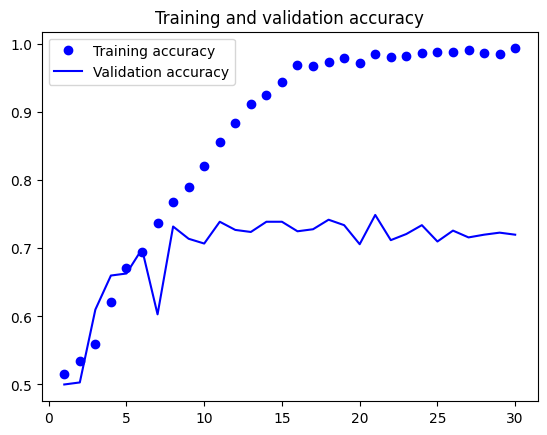

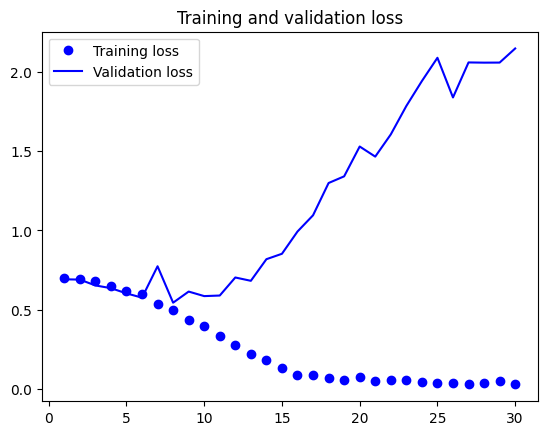

In [18]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Overfitting is evident, around epoch 6. 

**Evaluating the model on the test set**

In [19]:
test_model = keras.models.load_model("./models/convnet_from_scratch_1123.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

2024-11-23 22:42:24.661355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-11-23 22:42:24.661925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - 16s 241ms/step - loss: 0.5654 - accuracy: 0.7130
Test accuracy: 0.713


### Summary:
Model(convnet_from_scratch_1123): test accuracy is 0.713

### 3.2 Fine-Tune VGG16 (pre-trained on imagenet)

- Make sure to use validation to test for over-fitting. Plot the appropriate graph

**Instantiating the VGG16 convolutional base**

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


In [33]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

Here we define a new dense neural networks, of only two (neuronal/trainable) layers.

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [35]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction_1123.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 44ms/step - loss: 20.4105 - accuracy: 0.9185 - val_loss: 4.8456 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 3s 41ms/step - loss: 2.9027 - accuracy: 0.9780 - val_loss: 5.5260 - val_accuracy: 0.9630
Epoch 3/20
63/63 [==============================] - 2s 38ms/step - loss: 2.3831 - accuracy: 0.9810 - val_loss: 4.1589 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 2s 36ms/step - loss: 0.4333 - accuracy: 0.9950 - val_loss: 7.4632 - val_accuracy: 0.9680
Epoch 5/20
63/63 [==============================] - 2s 38ms/step - loss: 0.3776 - accuracy: 0.9965 - val_loss: 5.4601 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 2s 38ms/step - loss: 1.2773 - accuracy: 0.9925 - val_loss: 4.7615 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 2s 37ms/step - loss: 0.5056 - accuracy: 0.9935 - val_loss: 6.7920 - val_accuracy: 0.9690
Epoch 8/20
6

**Plotting the results**

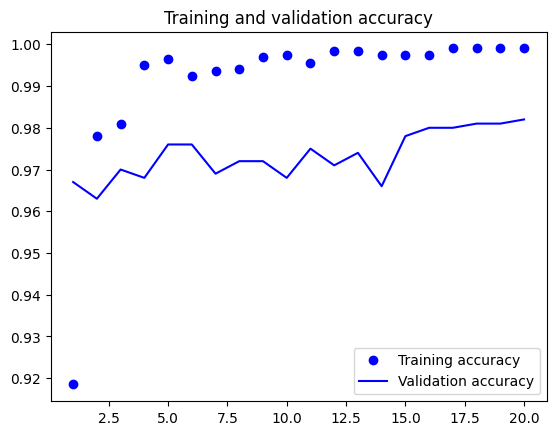

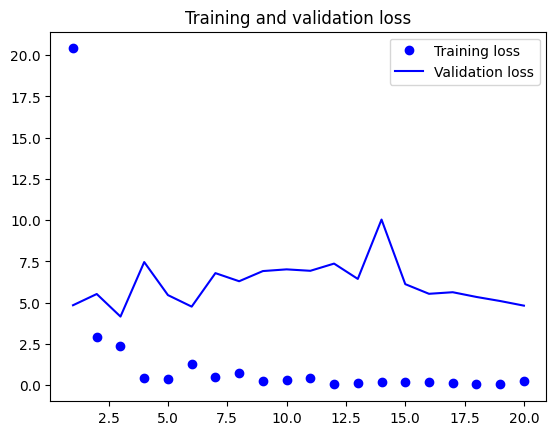

In [37]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [38]:
test_model = keras.models.load_model(
    "./models/feature_extraction_1123.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 6ms/step - loss: 4.9291 - accuracy: 0.9715
Test accuracy: 0.971


#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [39]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Adding a data augmentation stage and a classifier to the convolutional base**

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [41]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                           

In [42]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation_1123.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 298s 5s/step - loss: 19.3543 - accuracy: 0.8985 - val_loss: 19.2791 - val_accuracy: 0.9140
Epoch 2/50
63/63 [==============================] - 262s 4s/step - loss: 7.7206 - accuracy: 0.9455 - val_loss: 3.0521 - val_accuracy: 0.9770
Epoch 3/50
63/63 [==============================] - 262s 4s/step - loss: 5.7223 - accuracy: 0.9530 - val_loss: 3.5120 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 2231s 36s/step - loss: 5.1993 - accuracy: 0.9650 - val_loss: 4.9023 - val_accuracy: 0.9700
Epoch 5/50
63/63 [==============================] - 1459s 23s/step - loss: 5.6367 - accuracy: 0.9615 - val_loss: 3.2192 - val_accuracy: 0.9790
Epoch 6/50
63/63 [==============================] - 14807s 239s/step - loss: 4.1076 - accuracy: 0.9710 - val_loss: 3.5473 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 18677s 301s/step - loss: 3.5368 - accuracy: 0.9675 - val_loss: 6.2096 - val_accuracy: 0.9670

### Plot the result

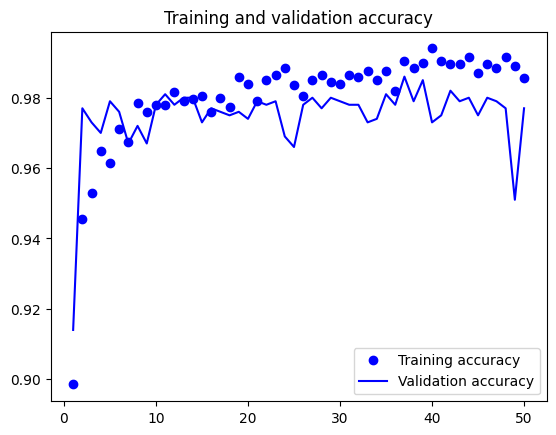

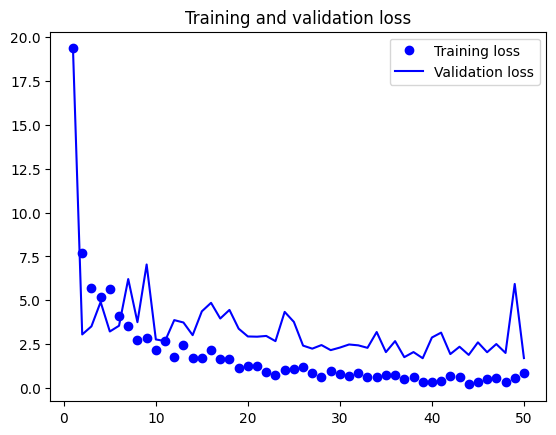

In [43]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [44]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation_1123.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 185s 3s/step - loss: 2.0451 - accuracy: 0.9770
Test accuracy: 0.977


### Fine-tuning a pretrained model

**Freezing all layers until the fourth from the last**

In [45]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [46]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                           

**Fine-tuning the model**

In [48]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning_1123.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 313s 5s/step - loss: 0.2381 - accuracy: 0.9905 - val_loss: 1.3471 - val_accuracy: 0.9850
Epoch 2/30
63/63 [==============================] - 303s 5s/step - loss: 0.2744 - accuracy: 0.9940 - val_loss: 1.4860 - val_accuracy: 0.9830
Epoch 3/30
63/63 [==============================] - 309s 5s/step - loss: 0.4824 - accuracy: 0.9915 - val_loss: 1.4627 - val_accuracy: 0.9830
Epoch 4/30
63/63 [==============================] - 299s 5s/step - loss: 0.4817 - accuracy: 0.9895 - val_loss: 1.5790 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 298s 5s/step - loss: 0.2347 - accuracy: 0.9945 - val_loss: 1.7145 - val_accuracy: 0.9810
Epoch 6/30
63/63 [==============================] - 289s 5s/step - loss: 0.1841 - accuracy: 0.9945 - val_loss: 1.7989 - val_accuracy: 0.9800
Epoch 7/30
63/63 [==============================] - 292s 5s/step - loss: 0.4181 - accuracy: 0.9885 - val_loss: 1.4607 - val_accuracy: 0.9800
Epoch 8/30
63

## plot the result

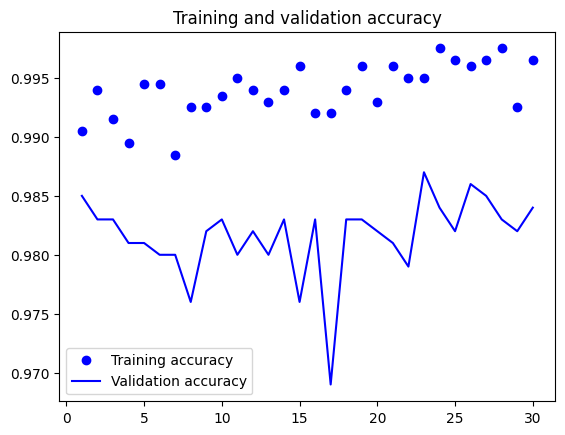

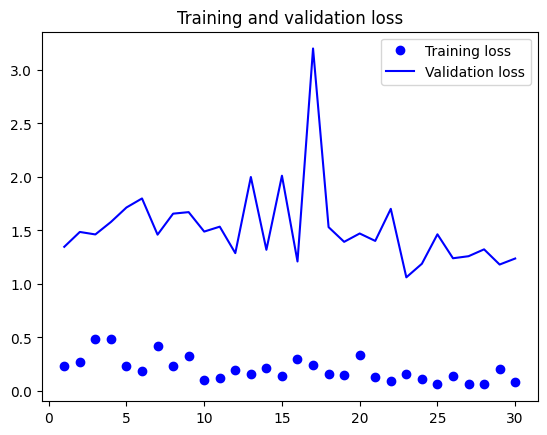

In [49]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [52]:
model = keras.models.load_model("./models/fine_tuning_1123.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 194s 3s/step - loss: 1.6192 - accuracy: 0.9770
Test accuracy: 0.977


### Summary:
I fine-tuned a pre-trained model by freezing all layers except for the top four. However, the test accuracy remains unchanged compared to freezing all layers. As a next step, I will try freezing all layers except for the top six and re-evaluate the test accuracy. See below:

In [53]:
conv_base.trainable = True
for layer in conv_base.layers[:-6]:
    layer.trainable = False

In [54]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning_1123_2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 354s 6s/step - loss: 0.1536 - accuracy: 0.9955 - val_loss: 1.3658 - val_accuracy: 0.9830
Epoch 2/30
63/63 [==============================] - 300s 5s/step - loss: 0.1678 - accuracy: 0.9970 - val_loss: 1.4949 - val_accuracy: 0.9870
Epoch 3/30
63/63 [==============================] - 296s 5s/step - loss: 0.0741 - accuracy: 0.9980 - val_loss: 1.2615 - val_accuracy: 0.9870
Epoch 4/30
63/63 [==============================] - 290s 5s/step - loss: 0.0888 - accuracy: 0.9965 - val_loss: 1.2293 - val_accuracy: 0.9880
Epoch 5/30
63/63 [==============================] - 287s 5s/step - loss: 0.0492 - accuracy: 0.9945 - val_loss: 1.2901 - val_accuracy: 0.9860
Epoch 6/30
63/63 [==============================] - 287s 5s/step - loss: 0.1234 - accuracy: 0.9960 - val_loss: 1.4976 - val_accuracy: 0.9830
Epoch 7/30
63/63 [==============================] - 288s 5s/step - loss: 0.0607 - accuracy: 0.9980 - val_loss: 1.3523 - val_accuracy: 0.9850
Epoch 8/30
63

In [55]:
model = keras.models.load_model("./models/fine_tuning_1123_2.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 190s 3s/step - loss: 1.5891 - accuracy: 0.9815
Test accuracy: 0.982


### Summary:
Test accuracy is 0.982, which is an increase compared to fine-tuning the top 4 layers（0.977）.

## 4. Explore the relative performance of the models (make sure to load the best version of each model) (6 points): 
- accuracy
- confusion metric
- precision, recall, F1-score,
- precision-recall curve.
- Explore specific examples in which the model failed to predict correctly.

### Accuracy

63/63 [==============================] - 16s 246ms/step - loss: 0.5654 - accuracy: 0.7130
ConvNet From Scratch - Test accuracy: 0.713
63/63 [==============================] - 0s 5ms/step - loss: 4.9291 - accuracy: 0.9715
Feature Extraction - Test accuracy: 0.971
63/63 [==============================] - 199s 3s/step - loss: 2.0451 - accuracy: 0.9770
Feature Extraction with Augmentation - Test accuracy: 0.977
63/63 [==============================] - 200s 3s/step - loss: 1.6192 - accuracy: 0.9770
Fine Tuning - Test accuracy: 0.977
63/63 [==============================] - 246s 4s/step - loss: 1.5891 - accuracy: 0.9815
Fine Tuning 2 - Test accuracy: 0.982


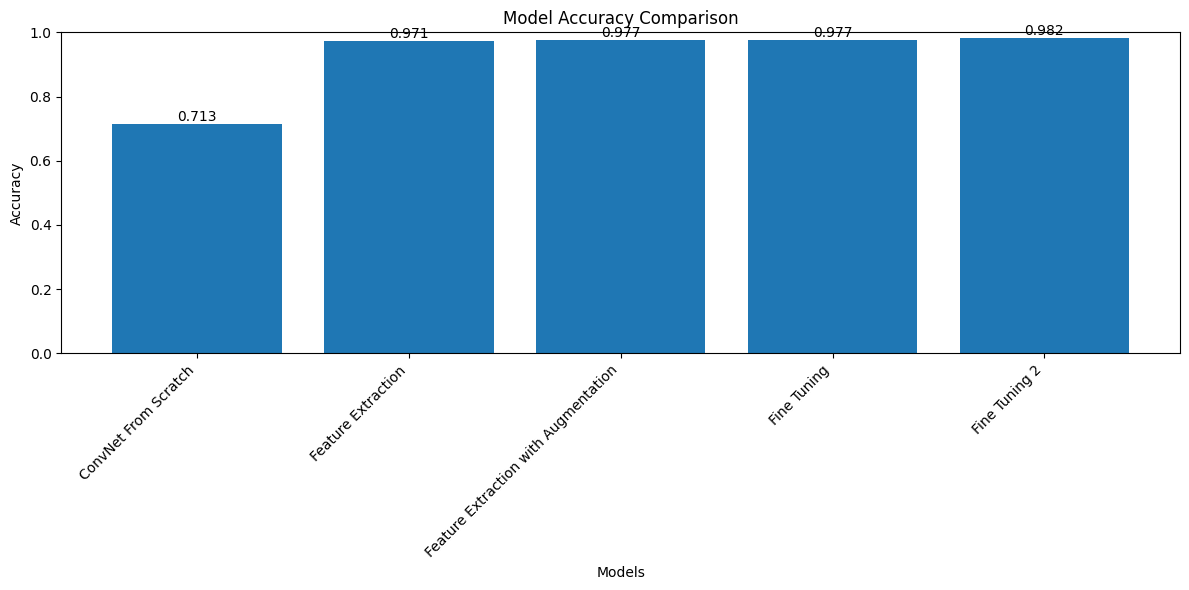

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Dictionary of models and their evaluation method
models = {
    'ConvNet From Scratch': {
        'path': './models/convnet_from_scratch_1123.keras',
        'use_features': False
    },
    'Feature Extraction': {
        'path': './models/feature_extraction_1123.keras',
        'use_features': True
    },
    'Feature Extraction with Augmentation': {
        'path': './models/feature_extraction_with_data_augmentation_1123.keras',
        'use_features': False
    },
    'Fine Tuning': {
        'path': './models/fine_tuning_1123.keras',
        'use_features': False
    },
    'Fine Tuning 2': {
        'path': './models/fine_tuning_1123_2.keras',
        'use_features': False
    }
}

# Evaluate models and store accuracies
accuracies = {}
for name, info in models.items():
    model = keras.models.load_model(info['path'])
    if info['use_features']:
        test_loss, test_acc = model.evaluate(x=test_features, y=test_labels)
    else:
        test_loss, test_acc = model.evaluate(test_dataset)
    accuracies[name] = test_acc
    print(f"{name} - Test accuracy: {test_acc:.3f}")

# Create bar plot
plt.figure(figsize=(12, 6))
names = list(accuracies.keys())
acc_values = list(accuracies.values())

bars = plt.bar(range(len(names)), acc_values)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)

# Rotate x-axis labels for better readability
plt.xticks(range(len(names)), names, rotation=45, ha='right')

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, 
            bar.get_height() + 0.01,
            f'{acc_values[i]:.3f}', 
            ha='center')

plt.tight_layout()
plt.show()

### Confusion Matrix


Evaluating ConvNet From Scratch...
63/63 [==============================] - 15s 237ms/step


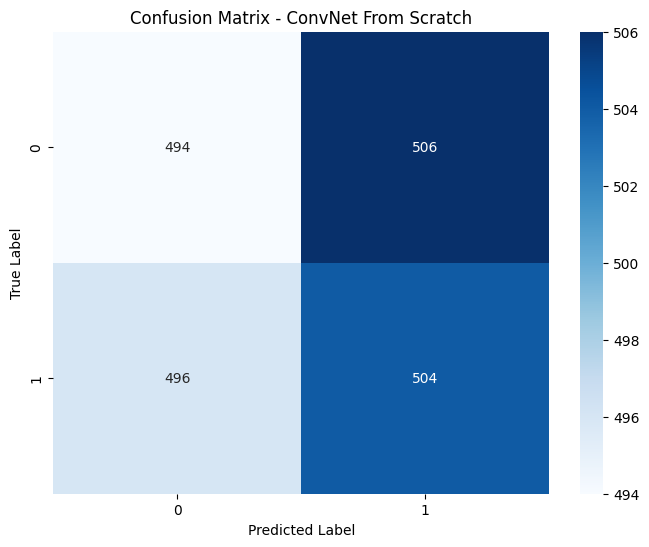


Evaluating Feature Extraction...
63/63 [==============================] - 0s 5ms/step


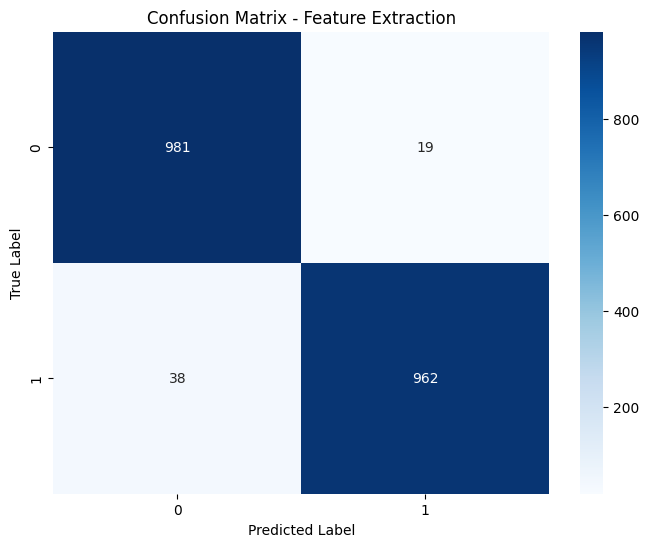


Evaluating Feature Extraction with Augmentation...
63/63 [==============================] - 309s 5s/step


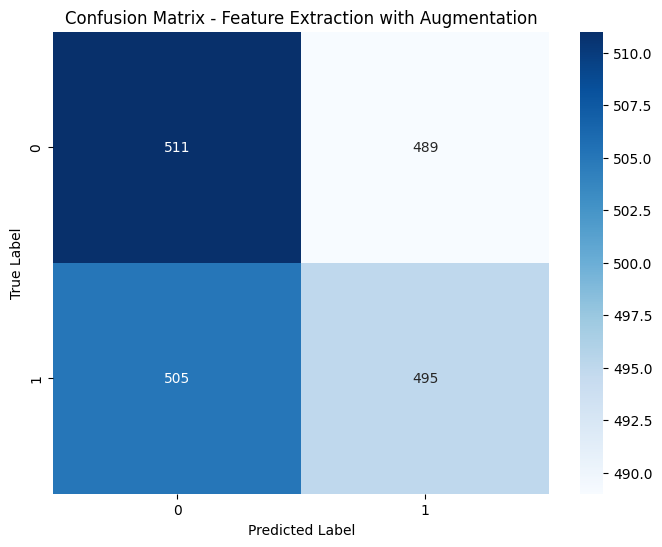


Evaluating Fine Tuning...
63/63 [==============================] - 1167s 19s/step


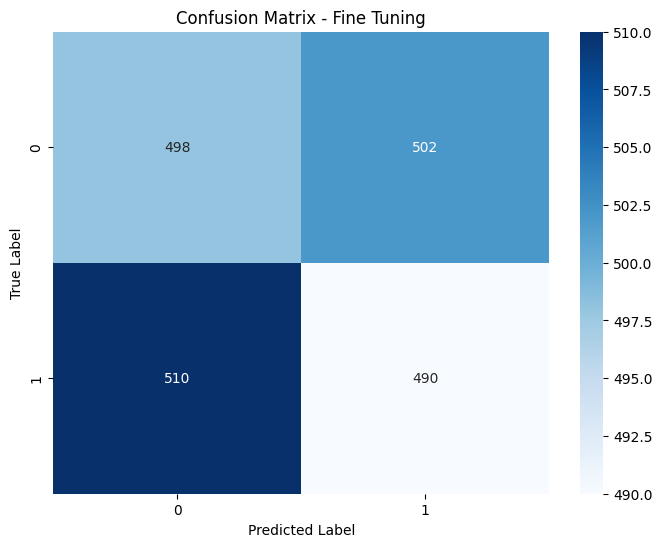


Evaluating Fine Tuning 2...
63/63 [==============================] - 196s 3s/step


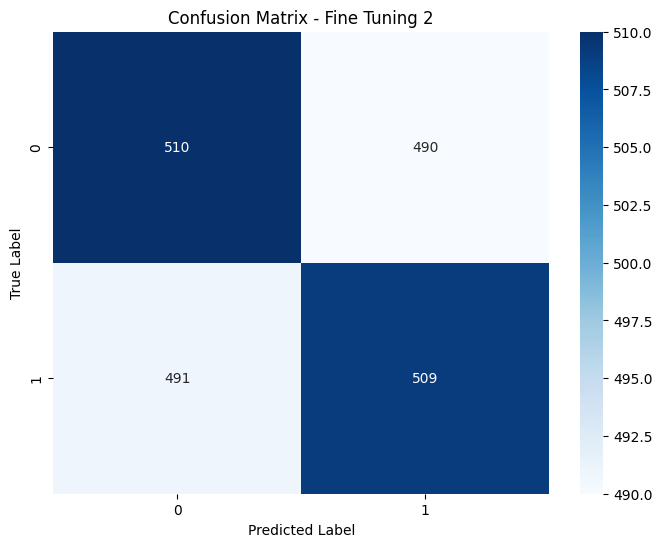

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def get_predictions(model, dataset, use_features=False):
    """Get predictions and true labels"""
    if use_features:
        predictions = model.predict(test_features)
        true_labels = test_labels
    else:
        # For dataset, we need to get all labels
        true_labels = np.concatenate([y for x, y in dataset])
        predictions = model.predict(dataset)
    
    # Convert predictions to binary (0 or 1)
    pred_labels = (predictions > 0.5).astype(int)
    return pred_labels, true_labels

def plot_confusion_matrix(model_name, pred_labels, true_labels):
    """Plot confusion matrix for a model"""
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Dictionary of models and their evaluation method
models = {
    'ConvNet From Scratch': {
        'path': './models/convnet_from_scratch_1123.keras',
        'use_features': False
    },
    'Feature Extraction': {
        'path': './models/feature_extraction_1123.keras',
        'use_features': True
    },
    'Feature Extraction with Augmentation': {
        'path': './models/feature_extraction_with_data_augmentation_1123.keras',
        'use_features': False
    },
    'Fine Tuning': {
        'path': './models/fine_tuning_1123.keras',
        'use_features': False
    },
    'Fine Tuning 2': {
        'path': './models/fine_tuning_1123_2.keras',
        'use_features': False
    }
}

# Plot confusion matrix for each model
for name, info in models.items():
    print(f"\nEvaluating {name}...")
    model = keras.models.load_model(info['path'])
    
    # Get predictions and true labels
    pred_labels, true_labels = get_predictions(
        model, 
        test_dataset, 
        use_features=info['use_features']
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(name, pred_labels, true_labels)

### precision, recall, F1-score,

In [68]:
from sklearn.metrics import classification_report

def get_predictions(model, dataset, use_features=False):
    """Get predictions and true labels"""
    if use_features:
        predictions = model.predict(test_features)
        true_labels = test_labels
    else:
        true_labels = np.concatenate([y for x, y in dataset])
        predictions = model.predict(dataset)
    
    # Convert predictions to binary
    pred_labels = (predictions > 0.5).astype(int)
    return pred_labels, true_labels

# Dictionary of models
models = {
    'ConvNet From Scratch': {
        'path': './models/convnet_from_scratch_1123.keras',
        'use_features': False
    },
    'Feature Extraction': {
        'path': './models/feature_extraction_1123.keras',
        'use_features': True
    },
    'Feature Extraction with Augmentation': {
        'path': './models/feature_extraction_with_data_augmentation_1123.keras',
        'use_features': False
    },
    'Fine Tuning': {
        'path': './models/fine_tuning_1123.keras',
        'use_features': False
    },
    'Fine Tuning 2': {
        'path': './models/fine_tuning_1123_2.keras',
        'use_features': False
    }
}

# Calculate and print metrics for each model
for name, info in models.items():
    print(f"\n=== {name} ===")
    print("-" * 50)
    
    # Load model
    model = keras.models.load_model(info['path'])
    
    # Get predictions
    pred_labels, true_labels = get_predictions(
        model, 
        test_dataset, 
        use_features=info['use_features']
    )
    
    # Print classification report
    print(classification_report(
        true_labels, 
        pred_labels,
        target_names=['Cats', 'Dogs']
    ))


=== ConvNet From Scratch ===
--------------------------------------------------
63/63 [==============================] - 16s 248ms/step
              precision    recall  f1-score   support

        Cats       0.50      0.49      0.50      1000
        Dogs       0.50      0.51      0.50      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000


=== Feature Extraction ===
--------------------------------------------------
63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

        Cats       0.96      0.98      0.97      1000
        Dogs       0.98      0.96      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


=== Feature Extraction with Augmentation ===
-------------------------------

### precision-recall curve

63/63 [==============================] - 190s 3s/step


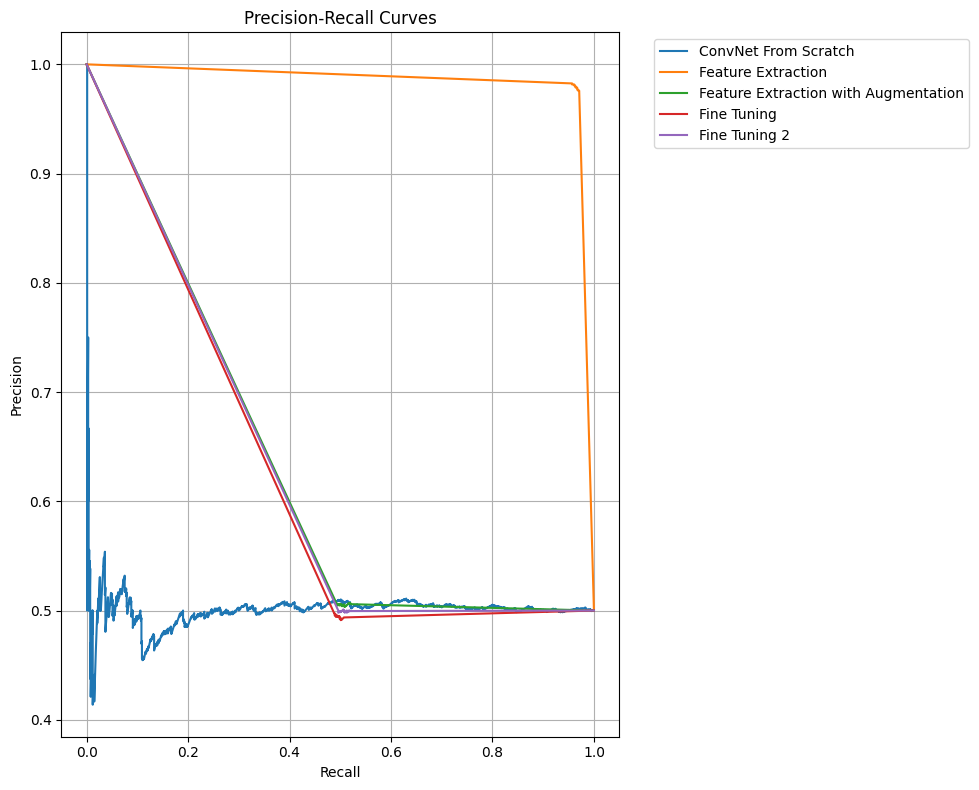

In [69]:
from sklearn.metrics import precision_recall_curve

def get_predictions(model, dataset, use_features=False):
   """Get predictions and true labels"""
   if use_features:
       predictions = model.predict(test_features)
       true_labels = test_labels
   else:
       true_labels = np.concatenate([y for x, y in dataset])
       predictions = model.predict(dataset)
   return predictions, true_labels

# Dictionary of models
models = {
   'ConvNet From Scratch': {
       'path': './models/convnet_from_scratch_1123.keras',
       'use_features': False
   },
   'Feature Extraction': {
       'path': './models/feature_extraction_1123.keras',
       'use_features': True
   },
   'Feature Extraction with Augmentation': {
       'path': './models/feature_extraction_with_data_augmentation_1123.keras',
       'use_features': False
   },
   'Fine Tuning': {
       'path': './models/fine_tuning_1123.keras',
       'use_features': False
   },
   'Fine Tuning 2': {
       'path': './models/fine_tuning_1123_2.keras',
       'use_features': False
   }
}

# Create precision-recall curves plot
plt.figure(figsize=(10, 8))

# Plot curves for each model
for name, info in models.items():
   # Load model
   model = keras.models.load_model(info['path'])
   
   # Get predictions
   predictions, true_labels = get_predictions(
       model, 
       test_dataset, 
       use_features=info['use_features']
   )
   
   # Calculate precision-recall curve
   precision, recall, _ = precision_recall_curve(true_labels, predictions)
   
   # Plot curve
   plt.plot(recall, precision, label=name)

# Customize plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Explore specific examples in which the model failed to predict correctly.


=== Misclassified Examples for ConvNet From Scratch ===
1/1 [==============================] - 0s 268ms/step


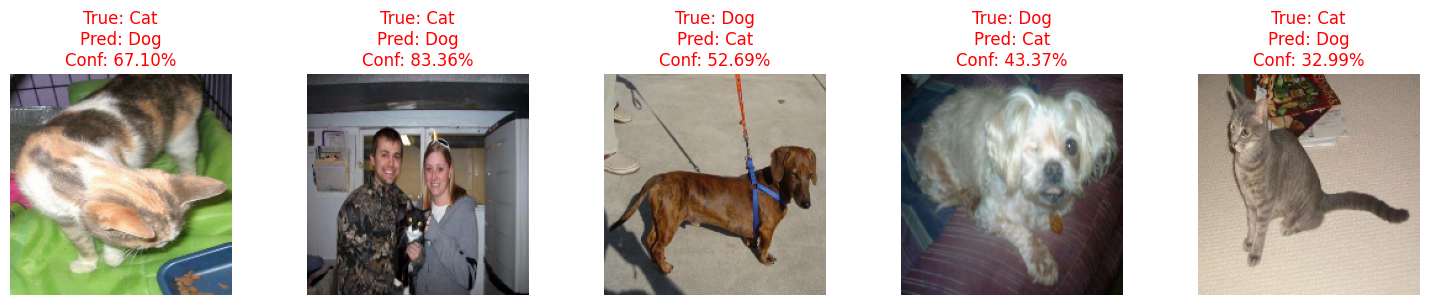


=== Misclassified Examples for Feature Extraction with Augmentation ===
1/1 [==============================] - 2s 2s/step


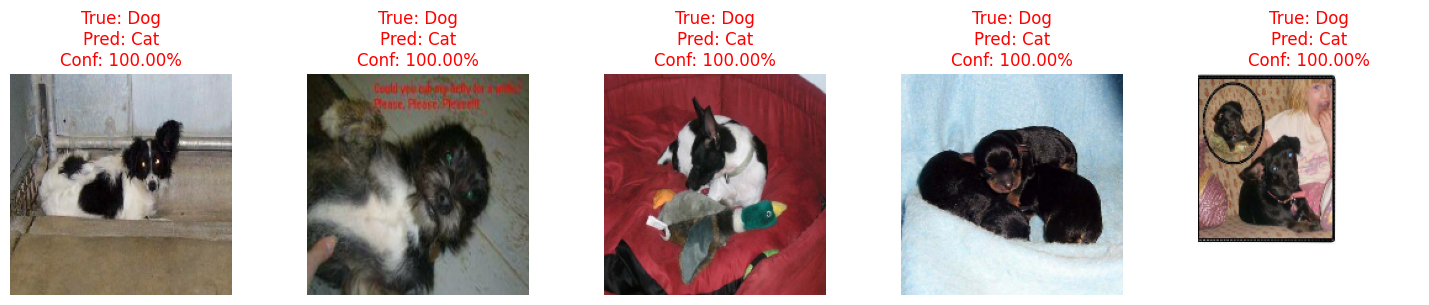


=== Misclassified Examples for Fine Tuning ===
1/1 [==============================] - 2s 2s/step


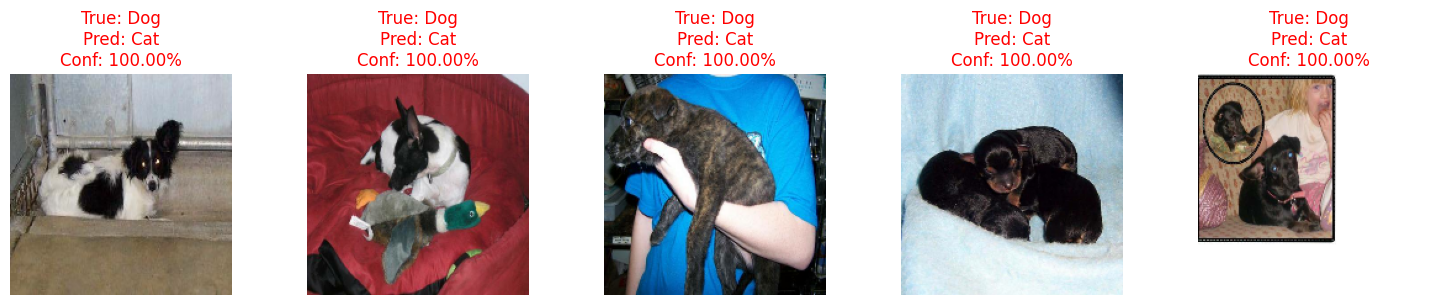


=== Misclassified Examples for Fine Tuning 2 ===
1/1 [==============================] - 2s 2s/step


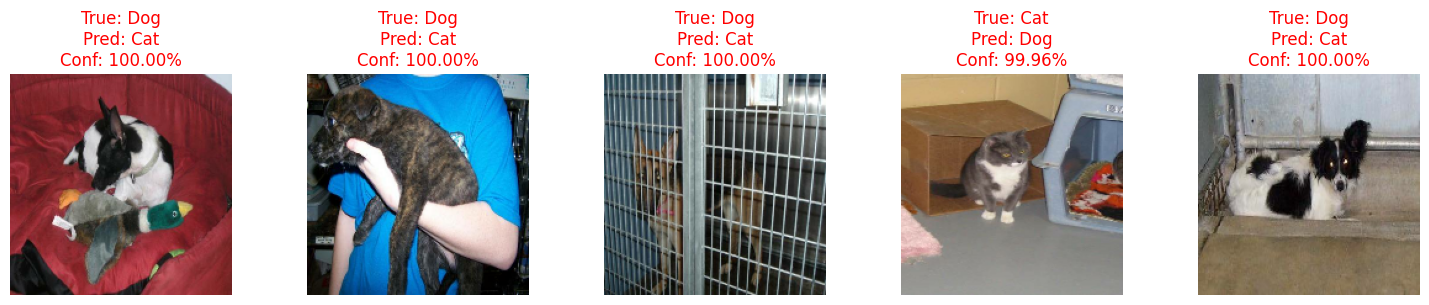

In [71]:

import matplotlib.pyplot as plt

def show_misclassified_examples(model, dataset, use_features=False, num_examples=5):
    """
    Show examples where the model made incorrect predictions
    
    Args:
        model: The trained model
        dataset: Test dataset
        use_features: Whether the model uses features or raw images
        num_examples: Number of misclassified examples to show
    """
    if use_features:
        predictions = model.predict(test_features)
        true_labels = test_labels
        print("Cannot show images for feature extraction model")
        return
    
    # Get predictions
    all_images = []
    all_labels = []
    predictions = []
    
    # Collect images and predictions
    for images, labels in dataset:
        preds = model.predict(images)
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())
        predictions.extend(preds)
    
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    predictions = np.array(predictions)
    pred_labels = (predictions > 0.5).astype(int)
    
    # Find misclassified examples
    misclassified_idx = np.where(pred_labels.flatten() != all_labels)[0]
    
    if len(misclassified_idx) == 0:
        print("No misclassified examples found!")
        return
    
    # Show the misclassified examples
    num_examples = min(num_examples, len(misclassified_idx))
    plt.figure(figsize=(15, 3))
    
    for i in range(num_examples):
        idx = misclassified_idx[i]
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(all_images[idx].astype("uint8"))
        plt.axis('off')
        
        true_label = "Cat" if all_labels[idx] == 0 else "Dog"
        pred_label = "Cat" if pred_labels[idx] == 0 else "Dog"
        confidence = abs(predictions[idx][0] - 0.5) * 2  # Convert to percentage
        
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}',
                 color='red' if true_label != pred_label else 'black')
    
    plt.tight_layout()
    plt.show()

# Dictionary of models
models = {
    'ConvNet From Scratch': {
        'path': './models/convnet_from_scratch_1123.keras',
        'use_features': False
    },
    'Feature Extraction with Augmentation': {
        'path': './models/feature_extraction_with_data_augmentation_1123.keras',
        'use_features': False
    },
    'Fine Tuning': {
        'path': './models/fine_tuning_1123.keras',
        'use_features': False
    },
    'Fine Tuning 2': {
        'path': './models/fine_tuning_1123_2.keras',
        'use_features': False
    }
}

# Show misclassified examples for each model
for name, info in models.items():
    print(f"\n=== Misclassified Examples for {name} ===")
    model = keras.models.load_model(info['path'])
    show_misclassified_examples(model, test_dataset, info['use_features'])

## Conclusions:

Fine-tuning_2 model(freezing all layers until last six layers) performs the best because it effectively combines VGG16's pre-trained weights with appropriate fine-tuning of later layers, achieving the highest accuracy in cats and dogs classification.